# Understanding User Perceptions of Movies: 
# A Sentiment and Network Analysis of Reviews, Ratings, and Genres

In this Notebook we analyze an IMDb dataset with hope to gain insight into what movie reviews from users can tell us about the movie, how movies are related by themes and if there is a pattern in audience engagement.

In [3]:
import os
import re
import pandas as pd
import numpy as np
from scipy.stats import pearsonr
from scipy.stats import f_oneway
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import os
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt

We begin by analyzing the sentiment of a sample of movie reviews for each movie in the dataset. Then combine the results with genre and rating data for each of the movies to see if there are some obvious patterns.

In [4]:

def load_sentiment_word_list(word_list_path):
    
    """ Loads the LabMT word list and return a dictionary of words and their happiness scores. """
    
    try:
        sentiment_words = pd.read_csv(
            word_list_path, sep="\t", comment="#", skip_blank_lines=True
        )
        return dict(zip(sentiment_words["word"], sentiment_words["happiness_average"]))
        
    except Exception as e:
        
        raise ValueError(f"Error reading word list: {e}")


def extract_word_list_from_reviews(file_path, max_reviews=100):
    
    """ Extracts a list of all words by sampling up to max_reviews reviews from a movie file (100) """
    
    try:
        movie_reviews = pd.read_csv(file_path)
        # Sample max_reviews reviews or take all if fewer exist
        sampled_reviews = movie_reviews["review"].dropna().sample(
            n=max_reviews, replace=False, random_state=42
        ) if len(movie_reviews) > max_reviews else movie_reviews["review"].dropna()
        # Combine all sampled reviews into one large text block, then split into words
        word_list = " ".join(sampled_reviews).split()
        return [word.lower() for word in word_list]
        
    except Exception as e:
        
        print(f"Error processing {file_path}: {e}")
        return []


def analyze_sentiment_for_words(word_list, happiness_dict):
    
    """ Analyzes the sentiment of a word list using the LabMT happiness dictionary. """
    
    positive_count = 0
    negative_count = 0
    scores = []

    for word in word_list:
        if word in happiness_dict:
            score = happiness_dict[word]
            scores.append(score)
            if score >= 6:
                positive_count += 1
            elif score <= 4:
                negative_count += 1

    avg_sentiment = np.mean(scores) if scores else np.nan
    
    return avg_sentiment, positive_count, negative_count


def strip_year_from_title(title):
    """ Remove the year from the end of a movie title (how it appears in the dataset) """
    
    return re.sub(r"\s+\d{4}$", "", title.strip())


def merge_genres_and_ratings(sentiment_df, genre_folder_path):
    
    """ Merge genres and ratings from genre files into the sentiment DataFrame. """
    
    genre_files = [
        os.path.join(genre_folder_path, f)
        for f in os.listdir(genre_folder_path)
        if f.endswith(".csv")
    ]
    genre_data = []
    for genre_file in genre_files:
        genre_name = os.path.basename(genre_file).replace(".csv", "")
        file_path = genre_file

        try:
            movies = pd.read_csv(file_path)[["name", "rating"]]
            movies["name"] = movies["name"].apply(strip_year_from_title)
            for _, row in movies.iterrows():
                genre_data.append({"movie": row["name"], "genre": genre_name, "rating": row["rating"]})
        except Exception as e:
            print(f"Error reading genre file {genre_file}: {e}")

    genre_df = pd.DataFrame(genre_data)
    
    # Merge genres and ratings into the sentiment DataFrame
    merged_df = sentiment_df.merge(genre_df, on="movie", how="left")
    grouped_df = merged_df.groupby("movie").agg({
        "avg_sentiment": "first",
        "positive_count": "first",
        "negative_count": "first",
        "word_count": "first",
        "genre": lambda x: list(x.dropna()),
        "rating": "first"
    }).reset_index()
    return grouped_df


def analyze_movie_sentiments(folder_path, word_list_path, genre_folder_path, max_reviews=100):
    
    """ Analyzes the average happiness score for movies, merge with genres and ratings. """
    
    happiness_dict = load_sentiment_word_list(word_list_path)

    results = []
    for file_name in os.listdir(folder_path):
        if file_name.endswith(".csv"):
            file_path = os.path.join(folder_path, file_name)
            # Extract all words by sampling up to max_reviews reviews
            word_list = extract_word_list_from_reviews(file_path, max_reviews)
            # Analyze the sentiment of the word list
            avg_sentiment, positive_count, negative_count = analyze_sentiment_for_words(word_list, happiness_dict)
            # Save the result with the movie title cleaned
            results.append({
                'movie': strip_year_from_title(file_name.replace('.csv', '')),
                'avg_sentiment': avg_sentiment,
                'positive_count': positive_count,
                'negative_count': negative_count,
                'word_count': len(word_list)
            })

    # Convert results to DataFrame
    sentiment_df = pd.DataFrame(results)

    # Merge genres and ratings
    sentiment_with_genres_and_ratings = merge_genres_and_ratings(sentiment_df, genre_folder_path)

    return sentiment_with_genres_and_ratings

folder_path = "reviews"  # Folder containing movie reviews
word_list_path = "labMIT-1.0.txt"  # The LabMT word list
genre_folder_path = "1_movies_per_genre"  # Folder containing genre files
max_reviews = 100 # We sample 100 movie reviews for each movie

movie_sentiments_with_genres_and_ratings = analyze_movie_sentiments(
    folder_path, word_list_path, genre_folder_path, max_reviews)

# Sort results to get top/bottom 10 movies
top_movies = movie_sentiments_with_genres_and_ratings.sort_values(by="avg_sentiment", ascending=False).head(10)
bottom_movies = movie_sentiments_with_genres_and_ratings.sort_values(by="avg_sentiment", ascending=True).head(10)

# Print results
print("Top 10 Movies with Highest Sentiment Scores:")
print(top_movies[["movie", "avg_sentiment", "positive_count", "negative_count", "rating", "genre"]].to_string(index=False))

print("\nTop 10 Movies with Lowest Sentiment Scores:")
print(bottom_movies[["movie", "avg_sentiment", "positive_count", "negative_count", "rating", "genre"]].to_string(index=False))

Top 10 Movies with Highest Sentiment Scores:
                                          movie  avg_sentiment  positive_count  negative_count  rating              genre
                                  Walk the Line       5.537905            4545             714     7.8 [Music, Biography]
                                            Elf       5.536370            3330             509     6.9          [Fantasy]
                             The Wedding Singer       5.533905            2807             422     6.8            [Music]
                                          Honey       5.527231            3936             662     5.4            [Music]
                               Music and Lyrics       5.520725            4241             616     6.5            [Music]
Eurovision Song Contest: The Story of Fire Saga       5.519760            1549             259     6.6            [Music]
                                  Dirty Dancing       5.519326            3416             578     7.

100 reviews were sampled for each movie since processing the over 1 million reviews was deamed unfeasible. 

We can clearly see some interesting patterns with the results for the 10 highest sentiment movie's reviews and the 10 lowest. The high sentiment movies are most in the Music genre, with some in Fantasy, Biography and Romance, while the low sentiment movies are in the War, Horror and History genres. The ratings for the two groups also seem similar as well as the positive word count. The sentiment of the reviews seems to follow the theme of the movie. This is very interesting, but we need to analyze more than 20 movies to fully draw conclusions.

In [50]:

def analyze_word_counts_and_ratings(sentiment_df, top_n=100):
    
    """ Analyze and compare the positive and negative word counts and ratings 
    for the top 100 and bottom 100 movies by average sentiment. """
    
    # Sort to get the top N and bottom N movies
    top_movies = sentiment_df.sort_values(by='avg_sentiment', ascending=False).head(top_n)
    bottom_movies = sentiment_df.sort_values(by='avg_sentiment', ascending=True).head(top_n)
    
    # Calculate averages for top N movies
    top_avg_positive = top_movies['positive_count'].mean()
    top_avg_negative = top_movies['negative_count'].mean()
    top_avg_rating = top_movies['rating'].mean()

    # Calculate averages for bottom N movies
    bottom_avg_positive = bottom_movies['positive_count'].mean()
    bottom_avg_negative = bottom_movies['negative_count'].mean()
    bottom_avg_rating = bottom_movies['rating'].mean()
    
    # Create a summary dictionary
    results = {
        "Top 100 Movies": {
            "Average Positive Word Count": top_avg_positive,
            "Average Negative Word Count": top_avg_negative,
            "Average Rating": top_avg_rating
        },
        "Bottom 100 Movies": {
            "Average Positive Word Count": bottom_avg_positive,
            "Average Negative Word Count": bottom_avg_negative,
            "Average Rating": bottom_avg_rating
        }
    }
    
    print("Comparison of Positive and Negative Word Counts and Ratings:\n")
    print(f"Top {top_n} Movies with Highest Sentiment Scores (Averages):")
    print(f"  Average Positive Word Count: {top_avg_positive}")
    print(f"  Average Negative Word Count: {top_avg_negative}")
    print(f"  Average Rating: {top_avg_rating}")
    
    print(f"\nBottom {top_n} Movies with Lowest Sentiment Scores (Averages):")
    print(f"  Average Positive Word Count: {bottom_avg_positive}")
    print(f"  Average Negative Word Count: {bottom_avg_negative}")
    print(f"  Average Rating: {bottom_avg_rating}")
    
    return results

comparison_results = analyze_word_counts_and_ratings(movie_sentiments_with_genres_and_ratings, top_n=100)


Comparison of Positive and Negative Word Counts and Ratings:

Top 100 Movies with Highest Sentiment Scores (Averages):
  Average Positive Word Count: 3784.13
  Average Negative Word Count: 634.09
  Average Rating: 7.391919191919191

Bottom 100 Movies with Lowest Sentiment Scores (Averages):
  Average Positive Word Count: 3510.3
  Average Negative Word Count: 1240.39
  Average Rating: 7.150505050505049


Here we can see the positive and negative word counts for the reviews with the highest and lowest sentiment scores. The difference in the positive word count is a bit surprising since it is very small, we would think that the lowest sentiment reviews would have very few positive words to show a dislike for the movie. The main difference in the high and low sentiment in reviews seems to lie in the negative word count. The lower sentiment movies have almost a double amount of negative words. We have also calculated the average rating for these films, but there does not seem to be a large difference between the low and high sentiment groups in ratings.

Is there a correlation between average sentiment of reviews and a movie's rating?

In [47]:

def perform_pearson_correlation(sentiment_df):
    
    """ Performs a Pearson correlation test between average sentiment and rating. """
    
    # Drop rows with missing or non-numeric values in avg_sentiment and rating
    filtered_df = sentiment_df.dropna(subset=["avg_sentiment", "rating"]).copy()
    filtered_df.loc[:, "rating"] = pd.to_numeric(filtered_df["rating"], errors="coerce")
    filtered_df = filtered_df.dropna(subset=["rating"])

    # Perform Pearson correlation test
    correlation, p_value = pearsonr(filtered_df["avg_sentiment"], filtered_df["rating"])

    # Print results
    print(f"Pearson Correlation: {correlation:.4f}")
    print(f"P-Value: {p_value:.4g}")

perform_pearson_correlation(movie_sentiments_with_genres_and_ratings)


Pearson Correlation: 0.0516
P-Value: 0.08194


The results from the Pearson test tell us with a low correlation coefficient and a high p-value (>0.05) that there is no evidence for a correlation between average sentiment and rating. These results are surprising as one might think that a movie with a low rating would have a very negative sentiment in reviews and a highly rated movie would have overall positive reviews. This tells us that there are other factors that affect a movie's review sentiment.

Is there a correlation between average sentiment score of reviews and a movie's genre?

In [43]:

def analyze_genre_sentiment_correlation(sentiment_df):
    
    """ Analyze the relationship between average sentiment scores and genres using the ANOVA method. """
    
    # Ensure genres are lists and explode them into separate rows
    sentiment_df = sentiment_df.explode('genre').dropna(subset=['genre', 'avg_sentiment'])
    
    # Group average sentiment scores by genres
    genre_groups = sentiment_df.groupby('genre')['avg_sentiment'].apply(list)
    
    # Perform ANOVA correlation test
    anova_result = f_oneway(*genre_groups)
    print("ANOVA Results:")
    print(f"F-statistic: {anova_result.statistic:.4f}, p-value: {anova_result.pvalue:.4g}")

analyze_genre_sentiment_correlation(movie_sentiments_with_genres_and_ratings)


ANOVA Results:
F-statistic: 78.4400, p-value: 2.992e-190


The results from the ANOVA test show that there is a highly significant relationship between genre and average sentiment in reviews with a very high F-statistic and a very low p-value (<0.05). This is exciting but the nature of this relationship remains unknown, for now.

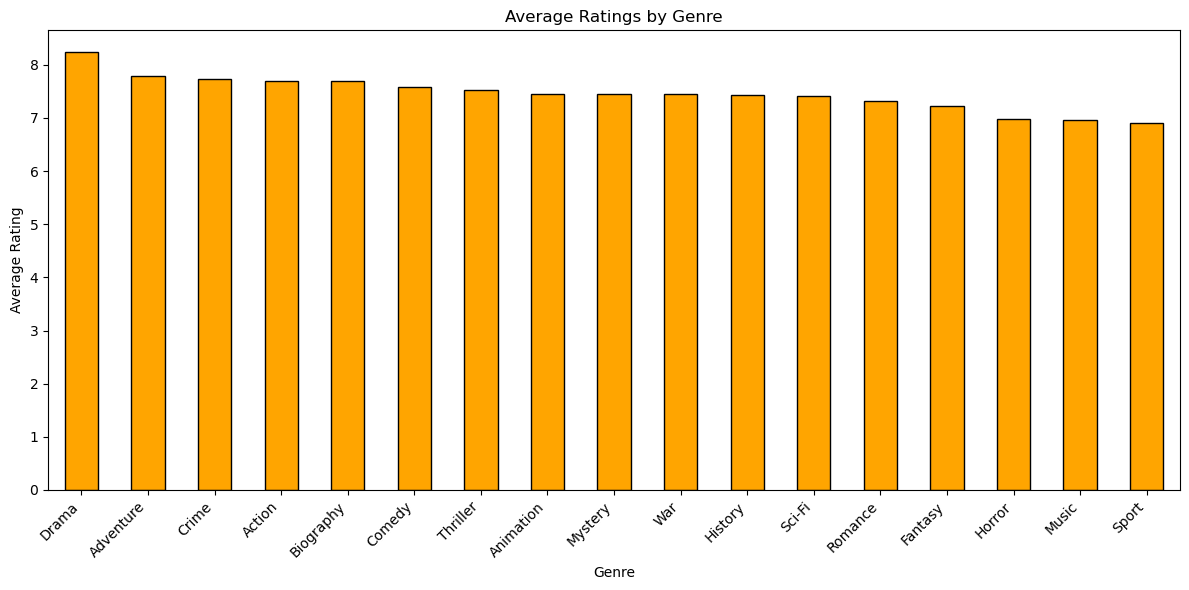

In [40]:

def plot_genre_ratings(sentiment_df):
    
    """ Plot the average rating for each genre. """
    
    # Explode the genre column into separate rows
    exploded_df = sentiment_df.explode('genre').dropna(subset=['genre', 'rating'])
    
    # Ensure ratings are numeric
    exploded_df['rating'] = pd.to_numeric(exploded_df['rating'], errors='coerce')
    
    # Calculate the average rating for each genre
    avg_ratings = exploded_df.groupby('genre')['rating'].mean().sort_values(ascending=False)
    
    # Plot the average ratings
    plt.figure(figsize=(12, 6))
    avg_ratings.plot(kind='bar', color='orange', edgecolor='black')
    plt.title("Average Ratings by Genre")
    plt.xlabel("Genre")
    plt.ylabel("Average Rating")
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

plot_genre_ratings(movie_sentiments_with_genres_and_ratings)


This plot shows the average rating for each genre. Drama has the highest average rating of around 8.4 while Sport films have the lowest. This is not very surprising as Oscar nominated films rather tend to belong to the Drama genre than Sport. There is not a very large difference in ratings between genres, but it still looks somewhat significant. Since there was not found to be correlation between sentiment in reviews and rating, this was not further investigated.

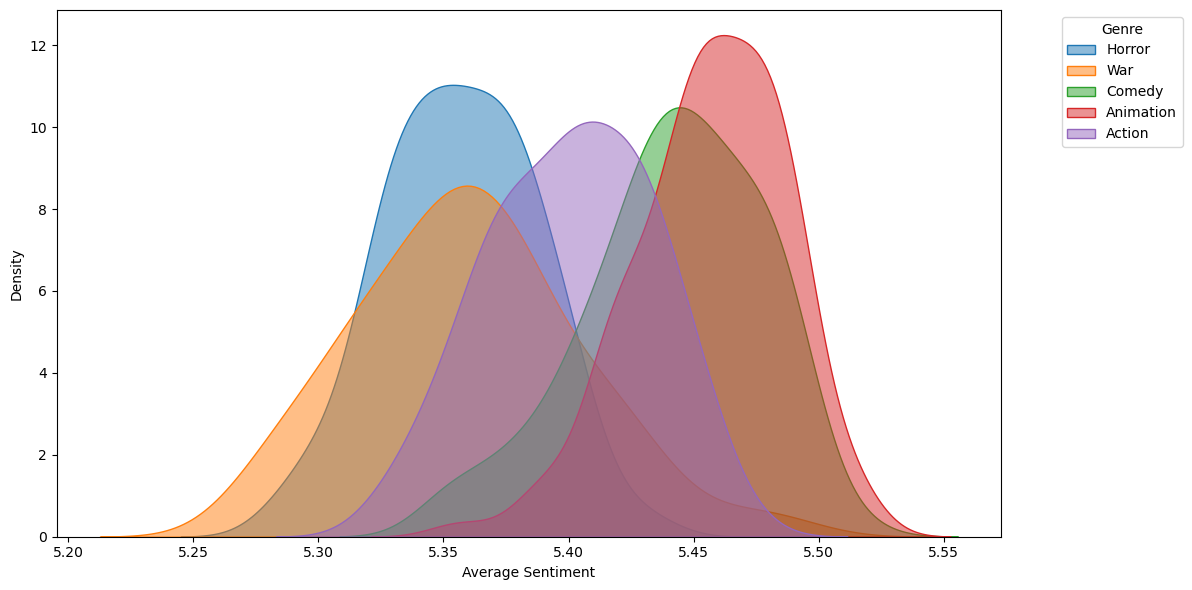

In [38]:

def plot_sentiment_density(sentiment_df):
    
    """ Plot the density of average sentiment scores for 5 specified genres with accurate legends. """
    
    # Explode the 'genre' column into separate rows
    exploded_df = sentiment_df.explode('genre').dropna(subset=['genre', 'avg_sentiment'])
    
    # Ensure the 'genre' column is a valid string type
    exploded_df['genre'] = exploded_df['genre'].astype(str)
    
    # Five different genres are selected for the plot
    selected_genres = ["Horror", "War", "Comedy", "Animation", "Action"]
    
    # Filter the DataFrame to include only these specific genres
    filtered_df = exploded_df[exploded_df['genre'].isin(selected_genres)]
    
    # Check if the filtered DataFrame is not empty
    if filtered_df.empty:
        print("No data available for the selected genres.")
        return

    # Create the plot explicitly for each genre
    plt.figure(figsize=(12, 6))
    for genre in selected_genres:
        genre_data = filtered_df[filtered_df['genre'] == genre]
        sns.kdeplot(
            data=genre_data,
            x="avg_sentiment",
            fill=True,
            alpha=0.5,
            common_norm=False,
            label=genre)

    plt.xlabel("Average Sentiment")
    plt.ylabel("Density")
    plt.legend(title="Genre", loc="upper right", bbox_to_anchor=(1.2, 1))
    plt.tight_layout()
    plt.savefig('sentiment_density_selected_genres.png', dpi=300)
    plt.show()

plot_sentiment_density(movie_sentiments_with_genres_and_ratings)


This plot shows the sentiment density in the reviews of the genres Horror, War, Comedy, Animation and Action. These genres were selected for the illustration because they show the range of the average sentiment well. Horror and War have a lower sentiment average, Comedy and Animation have a higher sentiment average and Action overlaps both groups. The genres that we would expect to have happier themes, Animation and Comedy have a density peak at a higher sentiment while Horror and War are the opposite.

In [35]:

def find_top_and_bottom_sentiment_genres(sentiment_df, top_n=3):
    
    """ Finds the top 3 (or n) genres with the highest and lowest average sentiment scores. """
    
    # Explode the 'genre' column into separate rows
    exploded_df = sentiment_df.explode('genre').dropna(subset=['genre', 'avg_sentiment'])
    
    # Ensure the 'genre' column is a valid string type
    exploded_df['genre'] = exploded_df['genre'].astype(str)
    
    # Group by genre and calculate the average sentiment for each genre
    genre_avg_sentiments = exploded_df.groupby('genre')['avg_sentiment'].mean().sort_values()
    
    # Get the top 3 lowest and highest average sentiment genres
    lowest_genres = genre_avg_sentiments.head(top_n)
    highest_genres = genre_avg_sentiments.tail(top_n)
    
    print(f"Top {top_n} Genres with the Highest Average Sentiment Scores:")
    print(highest_genres)
    print(f"\nTop {top_n} Genres with the Lowest Average Sentiment Scores:")
    print(lowest_genres)
    
    return highest_genres, lowest_genres

top_genres, bottom_genres = find_top_and_bottom_sentiment_genres(movie_sentiments_with_genres_and_ratings, top_n=3)


Top 3 Genres with the Highest Average Sentiment Scores:
genre
Romance      5.449432
Music        5.456101
Animation    5.456617
Name: avg_sentiment, dtype: float64

Top 3 Genres with the Lowest Average Sentiment Scores:
genre
Horror     5.356611
War        5.359588
Mystery    5.380261
Name: avg_sentiment, dtype: float64


Here are the top three genres with the highest and lowest average sentiment scores in their reviews. The highest sentiment genres generally have similar themes that are positive while the lowest are known to have negative or even scary themes. We know genre and average sentiment score are correlated but this gives us a better idea of how.

No matching genres found for movie: The Double Life of Véronique
No matching genres found for movie: Blade Runner 2049
No matching genres found for movie: Conquest 1453
No matching genres found for movie: Léon: The Professional
No matching genres found for movie: Nausicaä of the Valley of the Wind
No matching genres found for movie: The Legend of 1900
No matching genres found for movie: Salò, or the 120 Days of Sodom
No matching genres found for movie: Les Misérables
No matching genres found for movie: Amélie
Word cloud saved for genre: Horror -> wordclouds/Horror_wordcloud.png


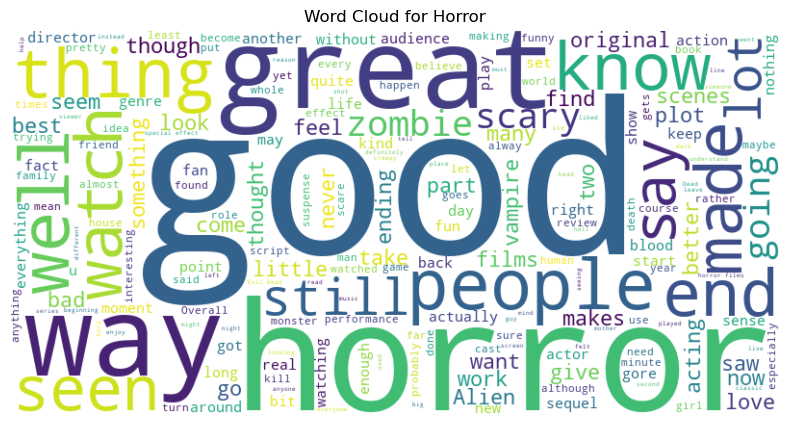

Word cloud saved for genre: Mystery -> wordclouds/Mystery_wordcloud.png


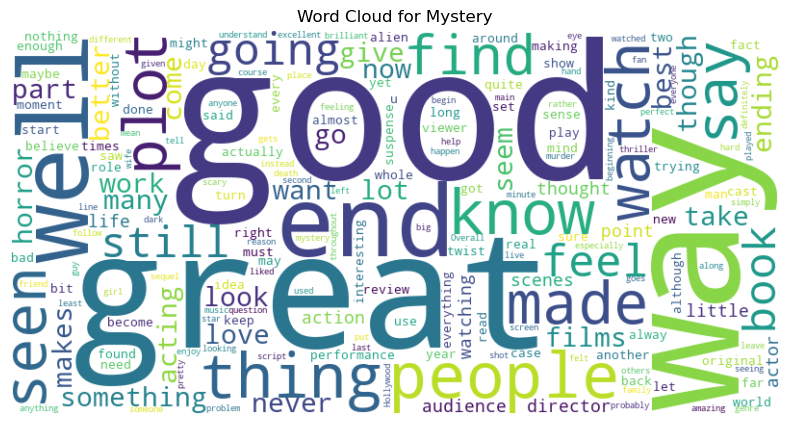

Word cloud saved for genre: Romance -> wordclouds/Romance_wordcloud.png


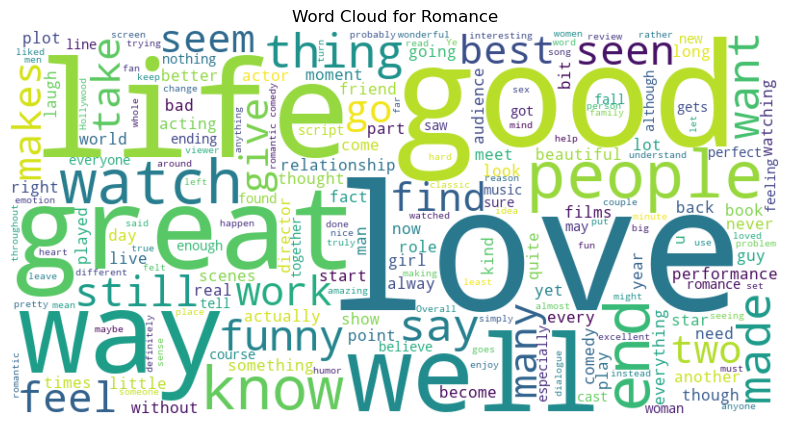

Word cloud saved for genre: Crime -> wordclouds/Crime_wordcloud.png


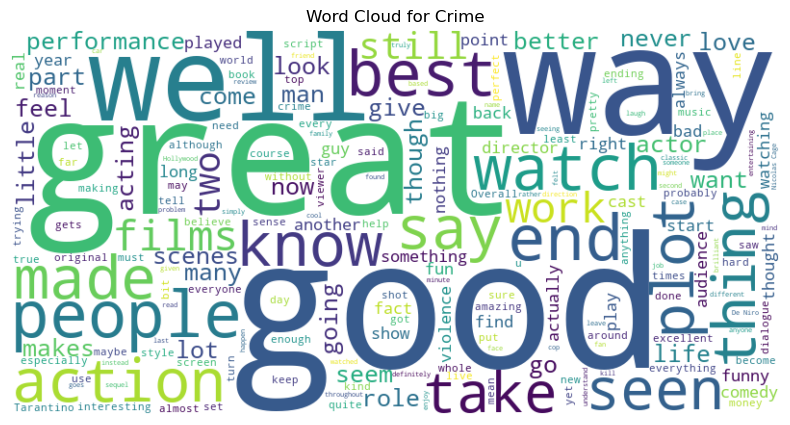

Word cloud saved for genre: Drama -> wordclouds/Drama_wordcloud.png


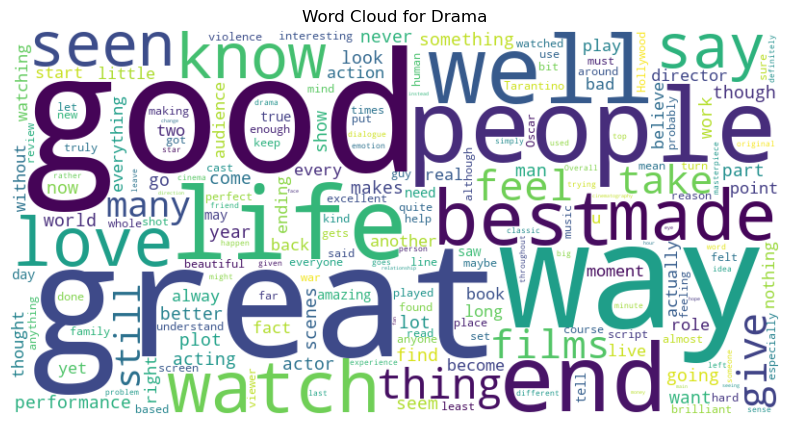

Word cloud saved for genre: Sci-Fi -> wordclouds/Sci-Fi_wordcloud.png


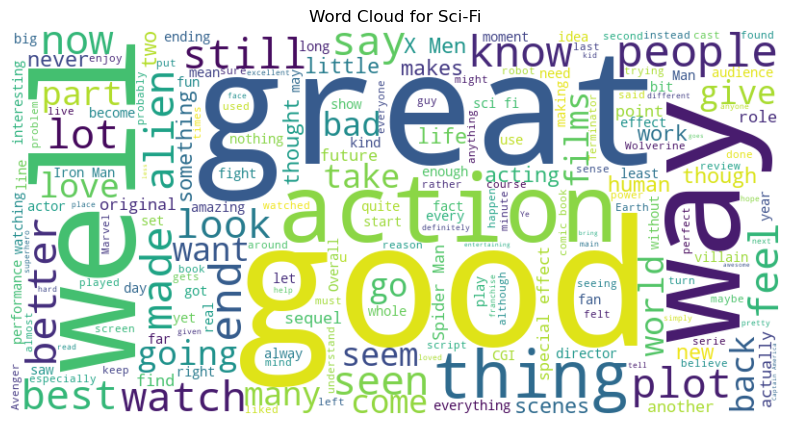

Word cloud saved for genre: Thriller -> wordclouds/Thriller_wordcloud.png


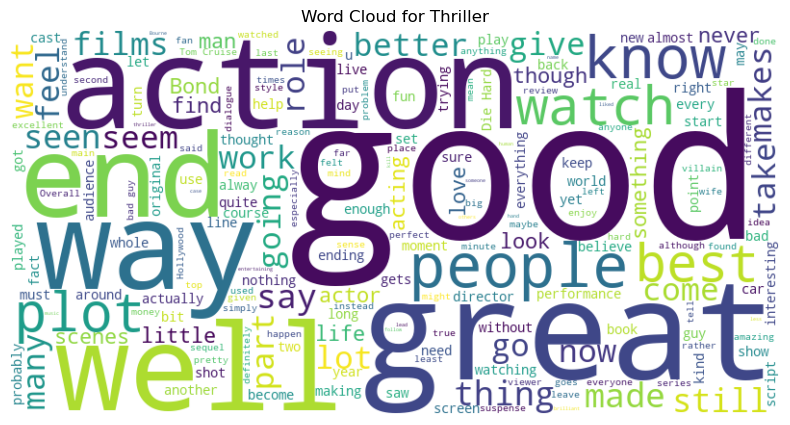

Word cloud saved for genre: History -> wordclouds/History_wordcloud.png


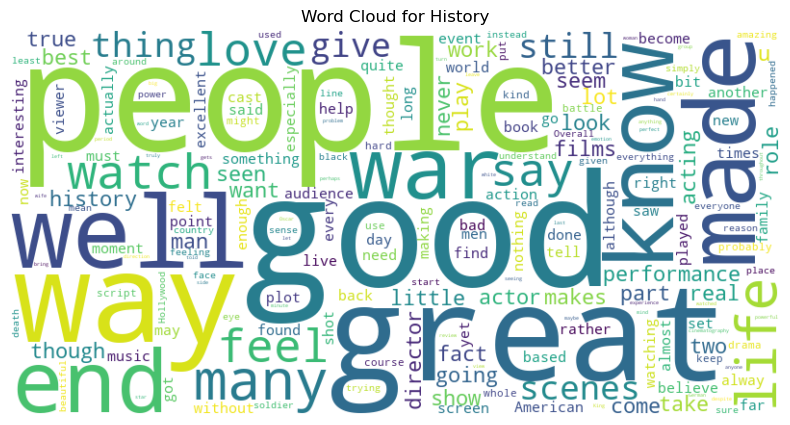

Word cloud saved for genre: Biography -> wordclouds/Biography_wordcloud.png


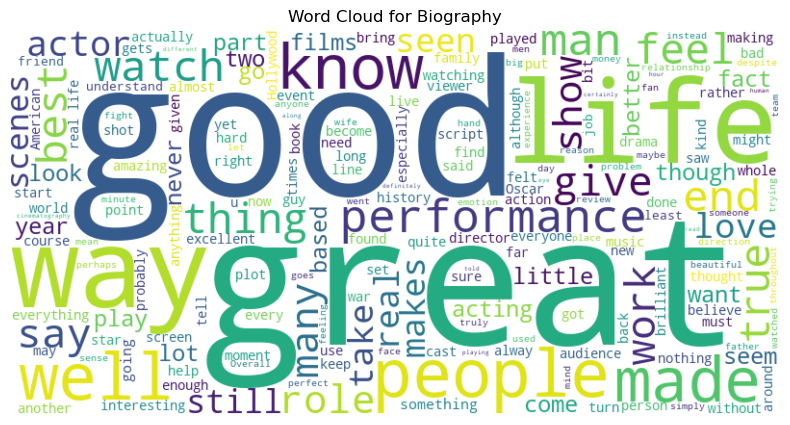

Word cloud saved for genre: War -> wordclouds/War_wordcloud.png


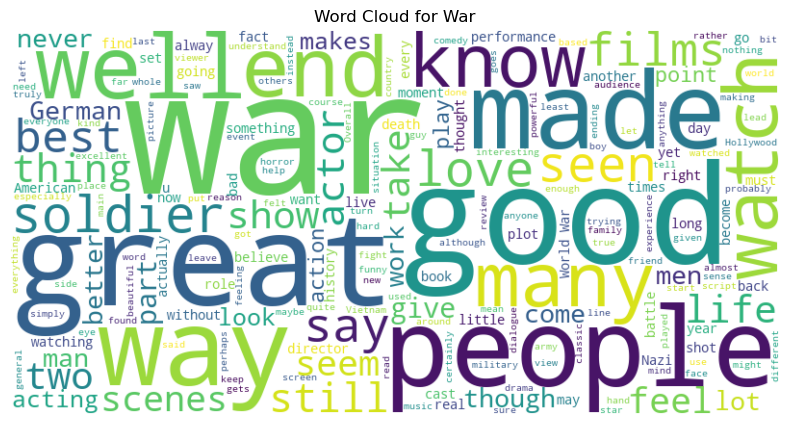

Word cloud saved for genre: Fantasy -> wordclouds/Fantasy_wordcloud.png


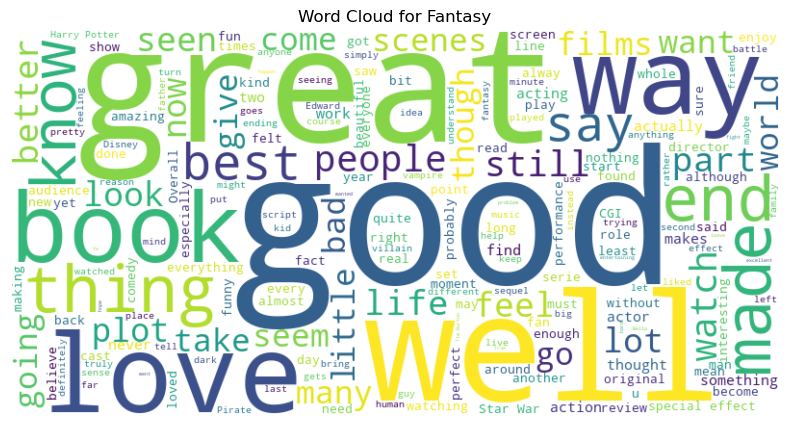

Word cloud saved for genre: Adventure -> wordclouds/Adventure_wordcloud.png


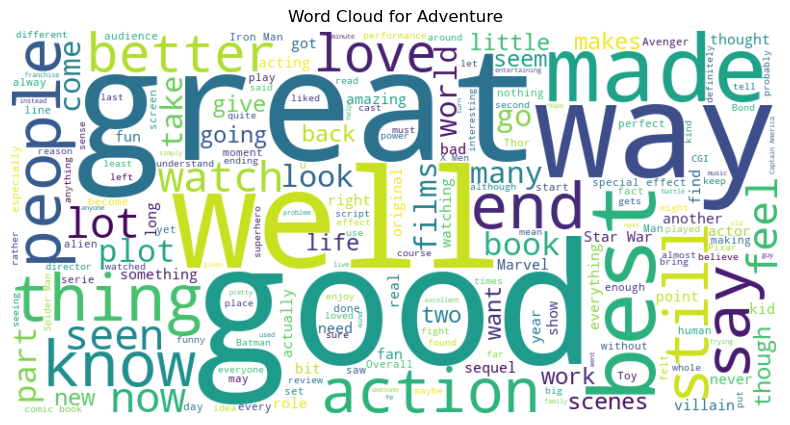

Word cloud saved for genre: Comedy -> wordclouds/Comedy_wordcloud.png


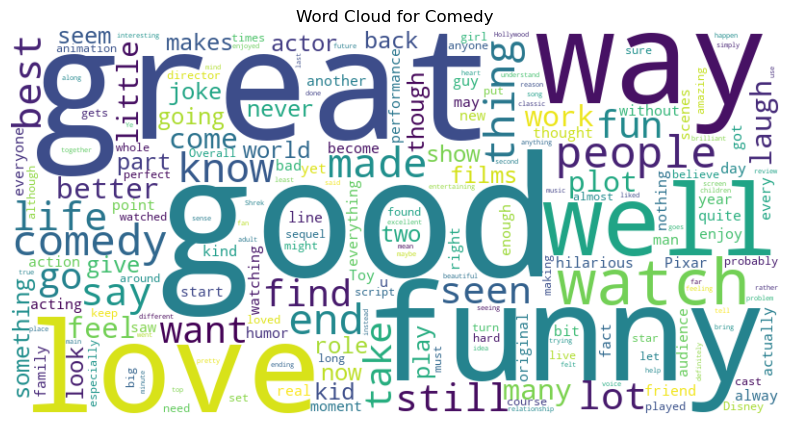

Word cloud saved for genre: Action -> wordclouds/Action_wordcloud.png


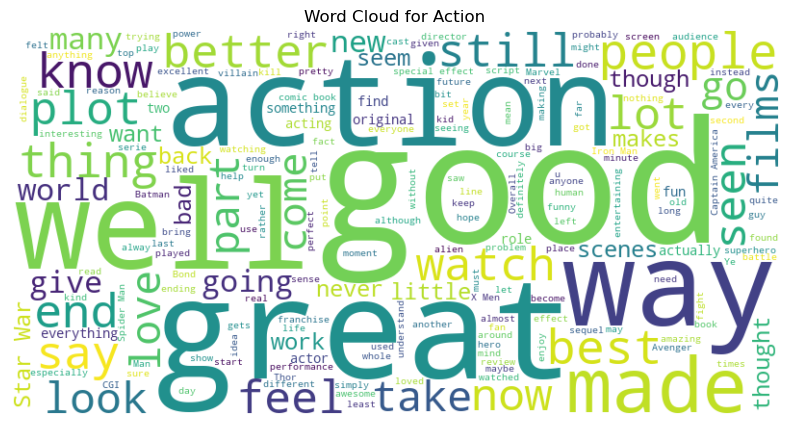

Word cloud saved for genre: Sport -> wordclouds/Sport_wordcloud.png


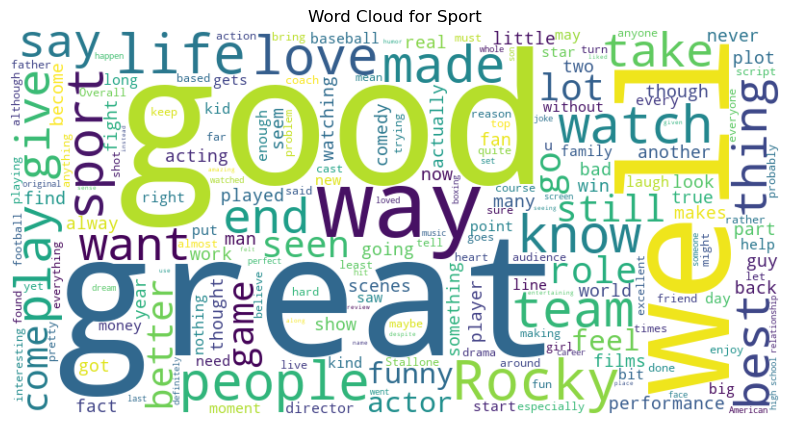

Word cloud saved for genre: Music -> wordclouds/Music_wordcloud.png


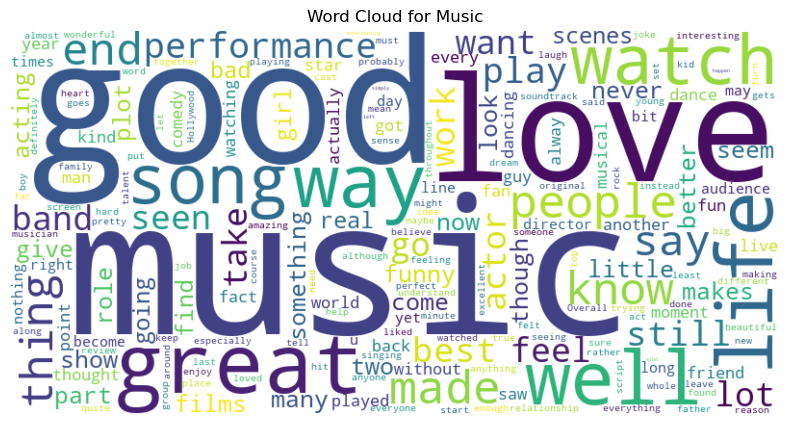

Word cloud saved for genre: Animation -> wordclouds/Animation_wordcloud.png


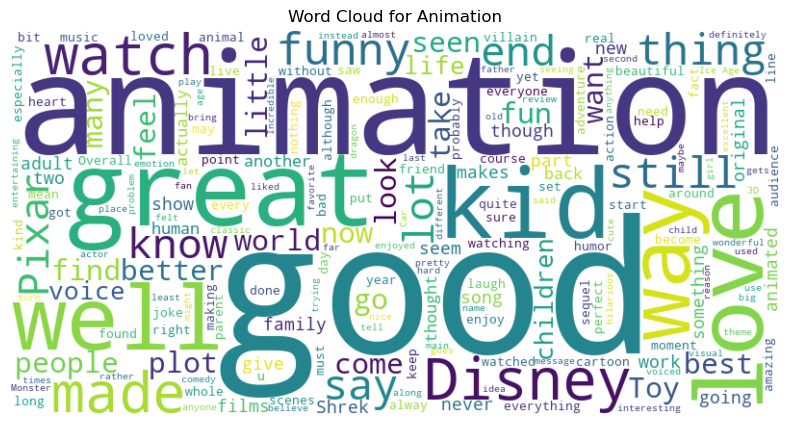

In [31]:

def normalize_title(title):
    # Remove years in the format "(YYYY)" or "YYYY"
    title = re.sub(r"\s*\(\d{4}\)", "", title)
    title = re.sub(r"\s+\d{4}$", "", title)
    # Strip extra spaces
    return title.strip()

def generate_word_clouds_by_genre_fixed(sentiment_df, reviews_folder_path, max_reviews=100, output_folder="wordclouds"):
    
    """ Generates word clouds for each genre based on user reviews. """
    
    genre_column = 'genre'
    
    # Explode the genre column into separate rows (some movies have multiple genres)
    exploded_df = sentiment_df.explode(genre_column).dropna(subset=[genre_column])
    
    # Normalize movie titles in the DataFrame (remove release year)
    exploded_df['normalized_movie'] = exploded_df['movie'].apply(normalize_title)
    
    # Create a dictionary to hold all text for each genre
    genre_texts = {genre: [] for genre in exploded_df[genre_column].unique()}

    # Additional stopwords added that appear frequently in the reviews and are non-specific to genre
    custom_stopwords = STOPWORDS.union({
        "movie", "film", "br", "one", "movies", "see", "time", "really", 
        "make", "much", "think", "scene", "character", "story", "characters", 
        "even", "will", "first"
    })

    # Iterate through the reviews folder
    for file_name in os.listdir(reviews_folder_path):
        if file_name.endswith(".csv"):
            # Normalize the movie title from the file name
            movie_title = normalize_title(os.path.splitext(file_name)[0])
            
            # Get genres for the current movie
            genres = exploded_df.loc[exploded_df['normalized_movie'] == movie_title, genre_column].dropna().unique()
            if not genres.any():  # Skip movies without matching genres
                print(f"No matching genres found for movie: {movie_title}")
                continue
            
            # Extract reviews and combine into text
            try:
                review_file = os.path.join(reviews_folder_path, file_name)
                movie_reviews = pd.read_csv(review_file)
                sampled_reviews = movie_reviews['review'].dropna().sample(
                    n=max_reviews, replace=False, random_state=42
                ) if len(movie_reviews) > max_reviews else movie_reviews['review'].dropna()
                combined_text = " ".join(sampled_reviews)
                
                # Add the text to each associated genre
                for genre in genres:
                    genre_texts[genre].append(combined_text)
            except Exception as e:
                print(f"Error processing reviews for movie: {movie_title}. Error: {e}")

    # Combine all text blocks for each genre
    for genre in genre_texts:
        genre_texts[genre] = " ".join(genre_texts[genre])

    # Generate word clouds for each genre
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    for genre, text in genre_texts.items():
        if text.strip():
            try:
                wordcloud = WordCloud(
                    width=800,
                    height=400,
                    background_color='white',
                    stopwords=custom_stopwords
                ).generate(text)
                
                # Save the word cloud as an image file
                output_file = os.path.join(output_folder, f"{genre}_wordcloud.png")
                wordcloud.to_file(output_file)
                print(f"Word cloud saved for genre: {genre} -> {output_file}")
                
                # Optionally display the word cloud
                plt.figure(figsize=(10, 5))
                plt.imshow(wordcloud, interpolation='bilinear')
                plt.title(f"Word Cloud for {genre}")
                plt.axis("off")
                plt.show()
            except Exception as e:
                print(f"Error generating word cloud for genre: {genre}. Error: {e}")

generate_word_clouds_by_genre_fixed(
    movie_sentiments_with_genres_and_ratings,
    folder_path,
    max_reviews=100,
    output_folder="wordclouds")


Above are wordclouds representing the text in a sample of 100 reviews for each genre. This should give us an idea what the most frequent words are in the reviews for each genre. The words 'good' and 'great' are large in all wordclouds and therefore appear frequently accross genres. What is interesting about the clouds are the negative words for certain genres. In the War wordcloud the words 'war', 'death', 'horror' and 'battle' can be spotted. These words have a very low happiness average in the labMT word list and drag the sentiment of the genre down. Similar words cannot be seen in the Comedy genre for example, where most of the words are positive and some neutral.